## 농산물 가격 예측 AI 경진대회_05-2. 다변량 LSTM 30일 
### 00. 모듈 & 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras

In [2]:
final_list = glob.glob('final_*.csv')
final_list

['final_cabbage.csv',
 'final_onion.csv',
 'final_oyster.csv',
 'final_redpepper.csv']

In [3]:
def load_data(algi, glob_list):
    for _ in glob_list:
        if algi in _:
            data = pd.read_csv(_)
            data.set_index('date',drop=True,inplace=True)
        
    data = data[data[data.columns[2]]!=0.0]
    data = data.fillna(0)
    
    return data

### 01. 데이터 전처리 함수

In [4]:
def make_dataset(data,window_size,target_size):
    #Encoding
    encoder = LabelEncoder()

    data['요일'] = encoder.fit_transform(data['요일'])
    data['계절'] = encoder.fit_transform(data['계절'])

    #Scaling
    Scaler = StandardScaler()
    Scaled = Scaler.fit_transform(data)

    #타겟 분리
    train = Scaled
    target = Scaled[:,2]

    #다변량 시계열 데이터셋 구성
    make = []
    make_t = []
    for i in range(len(train)-window_size-target_size):
        make.append(train[i:i+window_size])
        make_t.append(target[i+window_size:i+window_size+target_size])

    #타겟 분리
    train = np.array(make)
    target = np.array(make_t)
    print(train.shape, target.shape)
    return train, target, data

### 02. modeling 함수

In [5]:
def model_LSTM(argi):
    model = keras.models.Sequential([
        keras.layers.LSTM(30,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])),
        keras.layers.LSTM(30,return_sequences=True),
        keras.layers.LSTM(30,return_sequences=True),
        keras.layers.LSTM(30),
        keras.layers.Dense(30)
    ])

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(x_train, y_train, epochs=20,validation_data=(x_test, y_test))
    model.summary()
    print(model.evaluate(x_test, y_test))
    
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('%s LSTM residual'%argi)
    plt.show()
    
    y_pred = model.predict(x_test)
    
    return y_pred

### 03. 그래프 비교 함수

In [6]:
def comapare_plot(y_test,y_pred):
    yt = []
    yp = []

    for i in range(0,len(y_test),30):
        yt.append(y_pred[i,:])

    for i in range(0,len(y_pred),30):
        yp.append(y_pred[i,:])

    yt = np.array(yt).reshape(-1)
    yp = np.array(yp).reshape(-1)
    print(yp.shape,y_test.shape,len(y_test))

    y_test = y_test*np.mean(np.std(make_dataset(data,90,30)[2],axis=0))+np.mean(np.mean(make_dataset(data,90,30)[2]))
    y_pred = y_pred*np.mean(np.std(make_dataset(data,90,30)[2],axis=0))+np.mean(np.mean(make_dataset(data,90,30)[2]))
    
    plt.plot(y_test[:,-1],label='origin')
    plt.plot(y_pred[:,-1],label='predict')
    plt.title('compare %s precidtion'%argi)
    plt.legend()
    plt.show()
    
    plt.plot(y_test[30:,-1],label='origin')
    plt.plot(y_pred[:,-1],label='predict')
    plt.title('compare %s precidtion'%argi)
    plt.legend()
    plt.show()
    
    rmse = mean_squared_error(y_test,y_pred)
    print('RMSE : ',rmse)

### 04. 결과 비교
#### 04-1. 배추 가격

In [7]:
argi='cabbage'
data = load_data(argi,final_list)
data.head()

,요일,배추_거래량(kg)_x,배추_가격(원/kg),oil_price,배추_물가상승률,배추_잔차_1,배추_잔차_2,배추_잔차_5,배추_잔차_10,배추_잔차_15,...,배추_거래량_편차,배추_price_편차,계절,trand,seasonal,resid,평균기온(℃),최저기온(℃),최고기온(℃),강수량(mm)
date,,,,,,,,,,,,,,,,,,,,,
2016-01-02,토요일,80860.0,329,36.76,26.695083,329.0,0.0,0.0,0.0,0.0,...,-573897.3935,-116.903226,겨울,0.000000,103.406228,0.000000,5.122887,0.245070,11.655634,0.000000
2016-01-04,월요일,1422742.5,478,36.76,26.695083,478.0,149.0,0.0,0.0,0.0,...,767985.1065,32.096774,겨울,305.571429,85.311361,87.117210,5.416868,0.332782,10.153596,0.000000
2016-01-05,화요일,1167241.0,442,35.97,26.695083,-36.0,442.0,0.0,0.0,0.0,...,512483.6065,-3.903226,겨울,365.571429,78.228076,-1.799504,0.780713,-2.034934,4.213610,0.879112
2016-01-06,수요일,1045507.5,442,33.97,26.695083,0.0,-36.0,442.0,0.0,0.0,...,390750.1065,-3.903226,겨울,374.142857,91.469256,-23.612113,1.236381,-3.272112,5.575440,0.000000
2016-01-07,목요일,1039925.0,448,33.27,26.695083,6.0,6.0,119.0,0.0,0.0,...,385167.6065,2.096774,겨울,374.142857,74.270875,-0.413732,0.650924,-2.093016,4.373577,0.000000


In [8]:
train = make_dataset(data,90,30)[0]
target = make_dataset(data,90,30)[1]

(1360, 90, 23) (1360, 30)
(1360, 90, 23) (1360, 30)


In [9]:
#train test 분리
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, shuffle=False, random_state=120)
print('x_train.shape:',x_train.shape, 'x_train.shape:',y_train.shape)
print('x_test.shape:', x_test.shape, 'y_test.shape:',y_test.shape)

x_train.shape: (1088, 90, 23) x_train.shape: (1088, 30)
x_test.shape: (272, 90, 23) y_test.shape: (272, 30)


Epoch 1/20
34/34 [==============================] - 7s 113ms/step - loss: 0.5850 - val_loss: 0.6032
Epoch 2/20
34/34 [==============================] - 3s 75ms/step - loss: 0.2969 - val_loss: 0.3848
Epoch 3/20
34/34 [==============================] - 3s 86ms/step - loss: 0.2000 - val_loss: 0.3563
Epoch 4/20
34/34 [==============================] - 3s 94ms/step - loss: 0.1580 - val_loss: 0.3757
Epoch 5/20
34/34 [==============================] - 3s 92ms/step - loss: 0.1391 - val_loss: 0.3818
Epoch 6/20
34/34 [==============================] - 3s 91ms/step - loss: 0.1300 - val_loss: 0.4242
Epoch 7/20
34/34 [==============================] - 3s 91ms/step - loss: 0.1272 - val_loss: 0.4440
Epoch 8/20
34/34 [==============================] - 3s 95ms/step - loss: 0.1197 - val_loss: 0.4533
Epoch 9/20
34/34 [==============================] - 3s 94ms/step - loss: 0.1168 - val_loss: 0.4626
Epoch 10/20
34/34 [==============================] - 3s 90ms/step - loss: 0.1135 - val_loss: 0.4429
Epoch 11

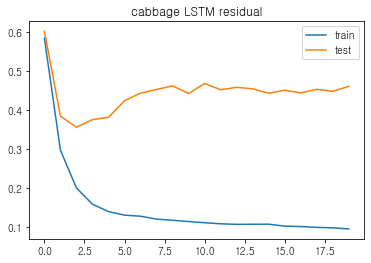

In [10]:
y_pred = model_LSTM(argi)

(300,) (272, 30) 272
(1360, 90, 23) (1360, 30)
(1360, 90, 23) (1360, 30)
(1360, 90, 23) (1360, 30)
(1360, 90, 23) (1360, 30)


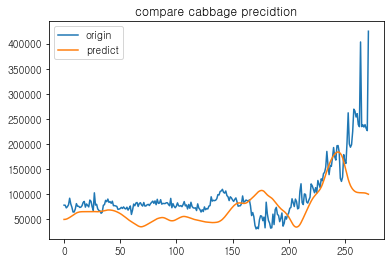

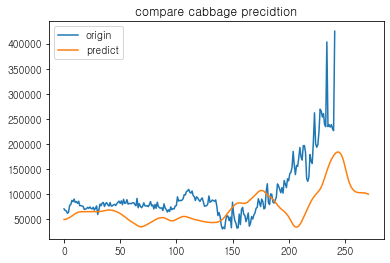

In [11]:
comapare_plot(y_test,y_pred)

#### 04-2. 양파 가격

In [12]:
argi='onion'
data = load_data(argi,final_list)
data.head()

,요일,양파_거래량(kg)_x,양파_가격(원/kg),oil_price,양파_물가상승률,양파_잔차_1,양파_잔차_2,양파_잔차_5,양파_잔차_10,양파_잔차_15,...,양파_거래량_편차,양파_price_편차,계절,trand,seasonal,resid,평균기온(℃),최저기온(℃),최고기온(℃),강수량(mm)
date,,,,,,,,,,,,,,,,,,,,,
2016-01-02,토요일,122787.5,1281,36.76,106.983795,1281.0,0.0,0.0,0.0,0.0,...,-1.045525e+06,271.225806,겨울,0.000000,96.139044,0.000000,5.176087,0.259130,11.742609,0.000000
2016-01-04,월요일,2315079.0,1235,36.76,106.983795,1235.0,-46.0,0.0,0.0,0.0,...,1.146767e+06,225.225807,겨울,890.428571,102.204600,242.366829,5.534736,0.411056,10.454118,0.000000
2016-01-05,화요일,2092960.1,1213,35.97,106.983795,-22.0,1213.0,0.0,0.0,0.0,...,9.246477e+05,203.225807,겨울,1064.428571,99.627966,48.943463,0.969665,-1.957369,4.530787,0.822242
2016-01-06,수요일,1860569.0,1263,33.97,106.983795,50.0,28.0,1263.0,0.0,0.0,...,6.922566e+05,253.225807,겨울,1054.285714,109.217902,99.496384,1.441086,-3.264188,5.971414,0.000000
2016-01-07,목요일,1868011.7,1241,33.27,106.983795,-22.0,28.0,-40.0,0.0,0.0,...,6.996993e+05,231.225807,겨울,1054.285714,100.003906,86.710380,1.049224,-1.720233,4.767794,0.000000


In [13]:
train = make_dataset(data,90,30)[0]
target = make_dataset(data,90,30)[1]

(1358, 90, 23) (1358, 30)
(1358, 90, 23) (1358, 30)


In [14]:
#train test 분리
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, shuffle=False, random_state=120)
print('x_train.shape:',x_train.shape, 'x_train.shape:',y_train.shape)
print('x_test.shape:', x_test.shape, 'y_test.shape:',y_test.shape)

x_train.shape: (1086, 90, 23) x_train.shape: (1086, 30)
x_test.shape: (272, 90, 23) y_test.shape: (272, 30)


Epoch 1/20
34/34 [==============================] - 9s 157ms/step - loss: 0.6126 - val_loss: 0.7989
Epoch 2/20
34/34 [==============================] - 5s 144ms/step - loss: 0.2679 - val_loss: 0.9096
Epoch 3/20
34/34 [==============================] - 5s 161ms/step - loss: 0.2080 - val_loss: 0.6145
Epoch 4/20
34/34 [==============================] - 5s 132ms/step - loss: 0.1437 - val_loss: 0.5266
Epoch 5/20
34/34 [==============================] - 5s 138ms/step - loss: 0.0991 - val_loss: 0.5623
Epoch 6/20
34/34 [==============================] - 5s 134ms/step - loss: 0.0800 - val_loss: 0.5837
Epoch 7/20
34/34 [==============================] - 4s 119ms/step - loss: 0.0648 - val_loss: 0.6803
Epoch 8/20
34/34 [==============================] - 4s 125ms/step - loss: 0.0597 - val_loss: 0.6573
Epoch 9/20
34/34 [==============================] - 4s 132ms/step - loss: 0.0560 - val_loss: 0.6545
Epoch 10/20
34/34 [==============================] - 5s 140ms/step - loss: 0.0521 - val_loss: 0.6226

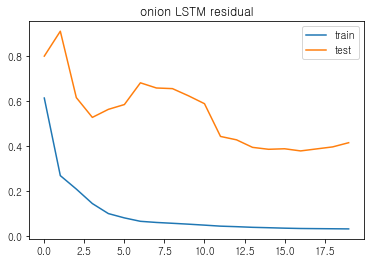

In [15]:
y_pred = model_LSTM(argi)

(300,) (272, 30) 272
(1358, 90, 23) (1358, 30)
(1358, 90, 23) (1358, 30)
(1358, 90, 23) (1358, 30)
(1358, 90, 23) (1358, 30)


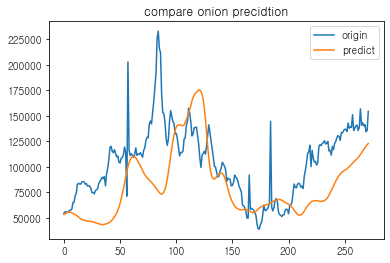

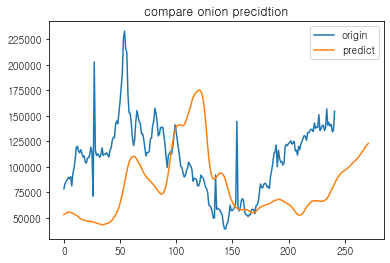

In [16]:
comapare_plot(y_test,y_pred)

#### 04-3. 새송이 가격

In [17]:
argi='oyster'
data = load_data(argi,final_list)
data.head()

,요일,새송이_거래량(kg)_x,새송이_가격(원/kg),oil_price,새송이_물가상승률,새송이_잔차_1,새송이_잔차_2,새송이_잔차_5,새송이_잔차_10,새송이_잔차_15,...,새송이_거래량_편차,새송이_price_편차,계절,trand,seasonal,resid,평균기온(℃),최저기온(℃),최고기온(℃),강수량(mm)
date,,,,,,,,,,,,,,,,,,,,,
2016-01-02,토요일,15797.0,2576,36.76,96.511532,2576.0,0.0,0.0,0.0,0.0,...,-126420.12900,385.774194,겨울,0.000000,272.383893,0.000000,5.143822,0.293436,11.596139,0.000000
2016-01-04,월요일,277326.5,2440,36.76,96.511532,2440.0,-136.0,0.0,0.0,0.0,...,135109.37100,249.774193,겨울,1726.714286,289.421442,423.864272,4.978925,-0.283642,9.611588,0.000000
2016-01-05,화요일,218465.2,2437,35.97,96.511532,-3.0,2437.0,0.0,0.0,0.0,...,76248.07097,246.774193,겨울,2048.714286,296.276850,92.008864,0.450786,-2.410408,4.194423,0.393873
2016-01-06,수요일,187900.4,2343,33.97,96.511532,-94.0,-97.0,2343.0,0.0,0.0,...,45683.27097,152.774193,겨울,2010.428571,297.607677,34.963752,0.636510,-4.110532,5.134031,0.000000
2016-01-07,목요일,181058.6,2291,33.27,96.511532,-52.0,-146.0,-285.0,0.0,0.0,...,38841.47097,100.774193,겨울,2010.428571,280.102183,0.469246,0.251000,-2.721801,4.168846,0.000000


In [18]:
train = make_dataset(data,90,30)[0]
target = make_dataset(data,90,30)[1]

(1355, 90, 23) (1355, 30)
(1355, 90, 23) (1355, 30)


In [19]:
#train test 분리
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, shuffle=False, random_state=120)
print('x_train.shape:',x_train.shape, 'x_train.shape:',y_train.shape)
print('x_test.shape:', x_test.shape, 'y_test.shape:',y_test.shape)

x_train.shape: (1084, 90, 23) x_train.shape: (1084, 30)
x_test.shape: (271, 90, 23) y_test.shape: (271, 30)


Epoch 1/20
34/34 [==============================] - 9s 131ms/step - loss: 0.8153 - val_loss: 0.6937
Epoch 2/20
34/34 [==============================] - 4s 130ms/step - loss: 0.5052 - val_loss: 0.6997
Epoch 3/20
34/34 [==============================] - 5s 139ms/step - loss: 0.3515 - val_loss: 0.7366
Epoch 4/20
34/34 [==============================] - 5s 134ms/step - loss: 0.2826 - val_loss: 0.8057
Epoch 5/20
34/34 [==============================] - 4s 129ms/step - loss: 0.2444 - val_loss: 0.8492
Epoch 6/20
34/34 [==============================] - 4s 126ms/step - loss: 0.2091 - val_loss: 0.9333
Epoch 7/20
34/34 [==============================] - 4s 131ms/step - loss: 0.1862 - val_loss: 0.8621
Epoch 8/20
34/34 [==============================] - 4s 130ms/step - loss: 0.1670 - val_loss: 0.8889
Epoch 9/20
34/34 [==============================] - 5s 150ms/step - loss: 0.1475 - val_loss: 0.9098
Epoch 10/20
34/34 [==============================] - 5s 136ms/step - loss: 0.1326 - val_loss: 0.8987

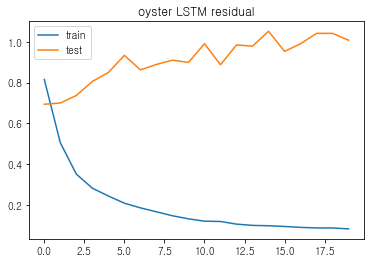

In [20]:
y_pred = model_LSTM(argi)

(300,) (271, 30) 271
(1355, 90, 23) (1355, 30)
(1355, 90, 23) (1355, 30)
(1355, 90, 23) (1355, 30)
(1355, 90, 23) (1355, 30)


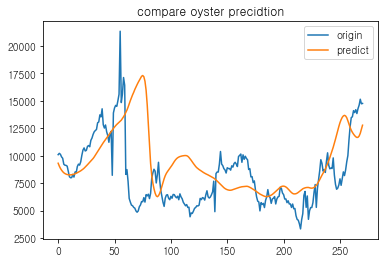

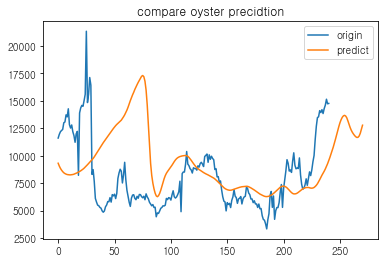

In [21]:
comapare_plot(y_test,y_pred)

#### 04-4. 건고추 가격

In [22]:
argi='redpepper'
data = load_data(argi,final_list)
data.head()

,요일,건고추_거래량(kg)_x,건고추_가격(원/kg),oil_price,건고추_물가상승률,건고추_잔차_1,건고추_잔차_2,건고추_잔차_5,건고추_잔차_10,건고추_잔차_15,...,건고추_거래량_편차,건고추_price_편차,계절,trand,seasonal,resid,평균기온(℃),최저기온(℃),최고기온(℃),강수량(mm)
date,,,,,,,,,,,,,,,,,,,,,
2016-01-02,토요일,3.0,11000,36.76,26.78983,11000.0,0.0,0.0,0.0,0.0,...,-1251.290323,5617.129032,겨울,0.000000,2870.835941,0.000000,5.394444,0.644444,11.577778,0.00000
2016-01-04,월요일,699.0,4464,36.76,26.78983,4464.0,-6536.0,0.0,0.0,0.0,...,-555.290323,-918.870968,겨울,4393.571429,1380.454396,-1310.025824,5.250000,0.023214,9.966071,0.00000
2016-01-05,화요일,1112.6,4342,35.97,26.78983,-122.0,4342.0,0.0,0.0,0.0,...,-141.690323,-1040.870968,겨울,5084.428571,1256.481579,-1998.910151,0.761111,-2.209259,4.409259,0.67037
2016-01-06,수요일,1672.0,7041,33.97,26.78983,2699.0,2577.0,7041.0,0.0,0.0,...,417.709677,1658.129032,겨울,4243.285714,818.306333,1979.407952,0.632812,-4.289062,5.312500,0.00000
2016-01-07,목요일,1191.0,3908,33.27,26.78983,-3133.0,-434.0,-7092.0,0.0,0.0,...,-63.290323,-1474.870968,겨울,4243.285714,1946.907837,-2282.193551,0.316129,-2.659677,4.217742,0.00000


In [23]:
train = make_dataset(data,90,30)[0]
target = make_dataset(data,90,30)[1]

(1339, 90, 23) (1339, 30)
(1339, 90, 23) (1339, 30)


In [24]:
#train test 분리
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, shuffle=False, random_state=120)
print('x_train.shape:',x_train.shape, 'x_train.shape:',y_train.shape)
print('x_test.shape:', x_test.shape, 'y_test.shape:',y_test.shape)

x_train.shape: (1071, 90, 23) x_train.shape: (1071, 30)
x_test.shape: (268, 90, 23) y_test.shape: (268, 30)


Epoch 1/20
34/34 [==============================] - 10s 151ms/step - loss: 0.5469 - val_loss: 2.7491
Epoch 2/20
34/34 [==============================] - 5s 133ms/step - loss: 0.4819 - val_loss: 2.6679
Epoch 3/20
34/34 [==============================] - 4s 129ms/step - loss: 0.4662 - val_loss: 2.6602
Epoch 4/20
34/34 [==============================] - 4s 129ms/step - loss: 0.4558 - val_loss: 2.6901
Epoch 5/20
34/34 [==============================] - 4s 128ms/step - loss: 0.4498 - val_loss: 2.6864
Epoch 6/20
34/34 [==============================] - 5s 134ms/step - loss: 0.4452 - val_loss: 2.6741
Epoch 7/20
34/34 [==============================] - 5s 133ms/step - loss: 0.4426 - val_loss: 2.6834
Epoch 8/20
34/34 [==============================] - 4s 133ms/step - loss: 0.4397 - val_loss: 2.7004
Epoch 9/20
34/34 [==============================] - 5s 143ms/step - loss: 0.4381 - val_loss: 2.6872
Epoch 10/20
34/34 [==============================] - 5s 136ms/step - loss: 0.4361 - val_loss: 2.717

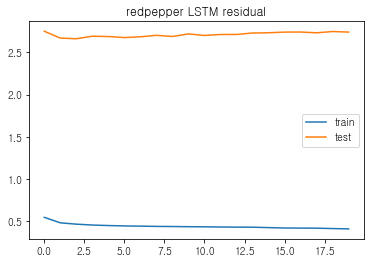

In [25]:
y_pred = model_LSTM(argi)

(270,) (268, 30) 268
(1339, 90, 23) (1339, 30)
(1339, 90, 23) (1339, 30)
(1339, 90, 23) (1339, 30)
(1339, 90, 23) (1339, 30)


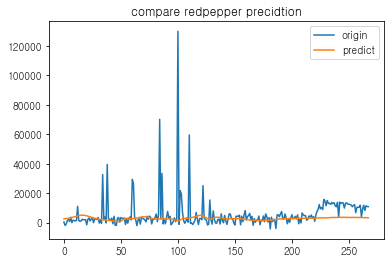

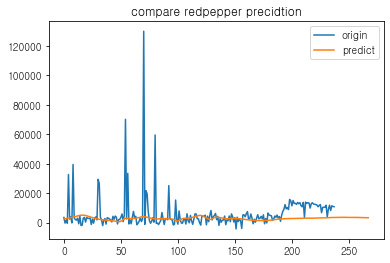

In [26]:
comapare_plot(y_test,y_pred)